# Column descriptions

### STAT_CAUSE_CODE	
- 1 = Lighting
- 2 = Equipment Use
- 3 = Smoking
- 4 = Campfire
- 5 = Debris Burning
- 6 = Railroad
- 7 = Arson
- 8 = Children
- 9 = Miscellaneous

### OWNER_CODE
- 5 = USFS (United States Forest Service)
- 6 = Other Federal
- 13 = State or Private
- 14 = Missing/Not Specified

### FIRESIZECLASS
Code for fire size based on the number of acres within the final fire perimeter expenditures 
- A=greater than 0 but less than or equal to 0.25 acres
- B=0.26-9.9 acres
- C=10.0-99.9 acres
- D=100-299 acres
- E=300 to 999 acres
- F=1000 to 4999 acres
- G=5000+ acres

### CONT_DATE 
##### Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy where mm=month, dd=day, and yyyy=year).
### CONT_DOY 
##### Day of year on which the fire was declared contained or otherwise controlled.
### CONT_TIME 
##### Time of day that the fire was declared contained or otherwise controlled (hhmm where hh=hour, mm=minutes).

# Libraries and Functions

In [276]:
#essentials for eda
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline

#modeling imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

#Model Libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [2]:
def encode_me(column, dataframe):
    '''
    Receive column name and dataframe and return dataframe with dummy variables and removed columns.
    column: String for the column we want to turn into dummy variables.
    dataframe: dataframe we will work with.
    '''
    dummies = pd.get_dummies(dataframe[column]) #creating dummy variables in our dataframe.
    dummies.drop(dummies.columns[0], axis=1, inplace=True) #dropping columns no longer needed
    rename_dict = {}
    for c in dummies.columns:
        rename_dict[c] = str(column) + '_' + str(c) 
    dummies.rename(columns = rename_dict,inplace=True) #renaming dataframe from dummies to orignal name
    dataframe = dataframe.join(dummies) #having the dataframe saved as the encoded data.
    dataframe.drop(column,axis=1, inplace=True)
    return dataframe

In [43]:
def class_report_todataframe(y,X):
    '''
    Enter y test and x test into function and will return classification report in form of a data 
    frame.
    y: y_test
    X: X_test predictions of the model. 
    '''
    return pd.DataFrame(classification_report(y, X, output_dict= True))

In [265]:
def feature_model_importances(model, df):

#loop to show name of column
    lst=[]
    for coef,columns in zip(list(df.columns),list(model.feature_importances_)):
        lst.append((columns,coef))
    keys_f =[]
    values_f =[]
    
    for l in sorted(lst):
        values_f.append(l[0])
        keys_f.append(l[1])

    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

    plt.rc('font', **font)
    plt.figure(figsize=(20,9))
    plt.bar(keys_f, values_f)
    plt.xticks(rotation=50);

    return plt.figure(figsize=(16,9))


# Eda And Data Cleaning

**Note:** I am only grabbing 100,000 sample of the data set because theres 1.8 million observations and for the sake of time and computing power I am limiting it but also giving me enough data for any rows I may drop and for my models can have enough training and test data.

In [10]:
pd_con = sqlite3.connect("Data/FPA_FOD_20170508.sqlite")
df = pd.read_sql_query("SELECT * FROM Fires LIMIT 100000;", pd_con)
pd.set_option('display.max_columns', None)
df

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,101068,FS-325949,FED,FS-FIRESTAT,FS,USORMHF,Mt. Hood National Forest,0606,Mt. Hood National Forest,25,None,None,WILSON,None,None,None,None,None,1997,2450691.5,243,1700,1.0,Lightning,2450692.5,244.0,1500,0.10,A,45.048611,-121.769167,5.0,USFS,OR,None,None,None,b'\x00\x01\xad\x10\x00\x00\xac4\xd7\x06:q^\xc0...
99996,99997,101069,FS-325950,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,90,None,None,PEEL,None,None,None,None,None,1997,2450685.5,237,1900,9.0,Miscellaneous,2450686.5,238.0,1800,1.00,B,40.016667,-120.753333,5.0,USFS,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x8c\xd5\xff\x9c60^\...
99997,99998,101070,FS-325951,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,91,None,None,MEADOW,None,None,None,None,None,1997,2450691.5,243,1409,9.0,Miscellaneous,2450691.5,243.0,1930,2.00,B,40.056667,-120.225000,5.0,USFS,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00dffff\x0e^\xc006{\xd...
99998,99999,101071,FS-325952,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,92,None,None,DOYLE,None,None,None,None,None,1997,2450692.5,244,1754,1.0,Lightning,2450692.5,244.0,2230,2.00,B,39.985000,-120.133333,5.0,USFS,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00D\xf4\x84\x88\x88\x0...


In [368]:
from IPython.display import display, Markdown
md = '<details><summary><b>Columns</b></summary>\n\n'
for column in df.columns:
    md+= '- {}\n\n'.format(column)
md+='</details>'
display(Markdown(md))

<details><summary><b>Columns</b></summary>

- SOURCE_REPORTING_UNIT_NAME

- FIRE_CODE

- FIRE_YEAR

- DISCOVERY_DATE

- DISCOVERY_DOY

- DISCOVERY_TIME

- STAT_CAUSE_CODE

- STAT_CAUSE_DESCR

- CONT_DATE

- CONT_DOY

- CONT_TIME

- FIRE_SIZE

- FIRE_SIZE_CLASS

- LATITUDE

- LONGITUDE

- OWNER_CODE

- OWNER_DESCR

- STATE

</details>

## Map visual

In [379]:
import plotly.graph_objects as go
fig = go.Figure(go.Densitymapbox(lat=df.LATITUDE, lon=df.LONGITUDE, radius=10))

fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=37)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('map.png')

## Looking at Wild Fires in each state

In [12]:
df.STATE.value_counts()

CA    19525
AZ    13897
OR    12093
ID     9826
MT     7164
NM     5789
CO     3521
WA     3403
UT     3269
WY     1820
MO     1737
MS     1500
FL     1400
AR     1343
NV     1252
NC     1089
MN     1083
SD     1062
KY     1012
MI      935
SC      888
AL      792
LA      765
TX      734
GA      606
TN      556
OK      544
OH      434
WI      394
VA      361
AK      289
IL      205
ND      147
IN      112
WV      106
NE      105
PA      100
KS       78
NH       38
VT       21
NY        3
ME        2
Name: STATE, dtype: int64

In [13]:
#looping through states to show show a visual in the next cell of where fires occur the most
state_fires = {}
for idx, row in df.iterrows():
    a = str(row.STATE)
    split = a.split(',')
    for x in split:
        if x in state_fires:
            state_fires[x] += 1
        else: 
            state_fires[x] = 1

In [376]:
states = pd.DataFrame(state_fires.items(), columns = ['States', 'count'])
states.head()

,States,count
0,CA,19525
1,NM,5789
2,OR,12093
3,NC,1089
4,WY,1820


##### Checking out the top 5 states with the most fires.

In [173]:
states_top_five = states.sort_values(['count'], ascending=False)[0:5]
states_top_five

,States,count
0,CA,19525
9,AZ,13897
2,OR,12093
13,ID,9826
7,MT,7164


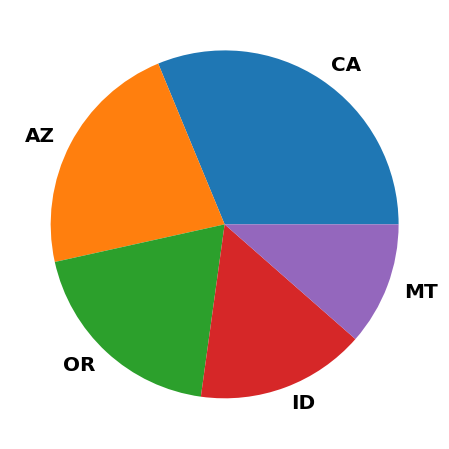

In [177]:
v = state_fires.values() 
k = state_fires.keys()  
f = [float(x) for x in v]  
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.pie(states_top_five['count'], labels =states_top_five['States'], autopct=None)

plt.show()

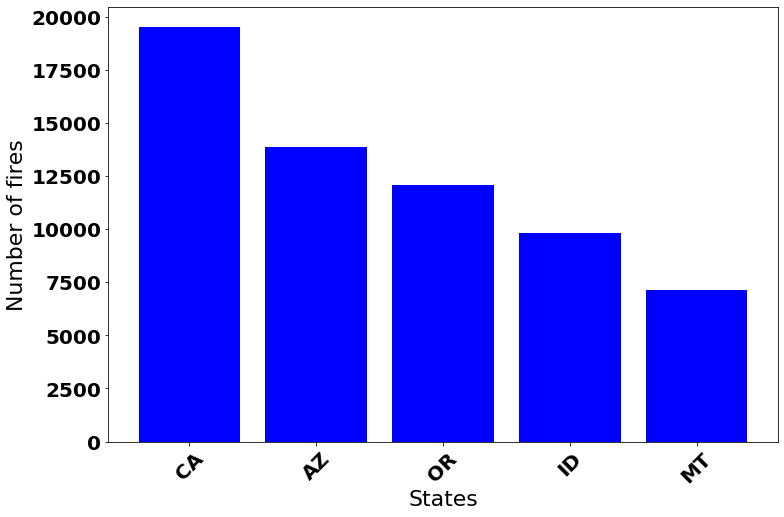

In [181]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.bar(states_top_five['States'], states_top_five['count'], color = 'blue')
plt.ylabel('Number of fires')
plt.xlabel('States')
plt.xticks(range(0,5), rotation=45)
plt.savefig('US wildfires')

In [19]:
df.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [20]:
df = df.drop(columns = ['Shape', 'OBJECTID', 'FPA_ID', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                        'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME',
                       'FOD_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'SOURCE_REPORTING_UNIT',
                        'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME'])
df.head()

,SOURCE_REPORTING_UNIT_NAME,FIRE_CODE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE
0,Plumas National Forest,BJ8K,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA
1,Eldorado National Forest,AAC0,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA
2,Eldorado National Forest,A32W,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA
3,Eldorado National Forest,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA
4,Eldorado National Forest,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Mt. Hood National Forest,None,1997,2450691.5,243,1700,1.0,Lightning,2450692.5,244.0,1500,0.10,A,45.048611,-121.769167,5.0,USFS,OR
99996,Plumas National Forest,None,1997,2450685.5,237,1900,9.0,Miscellaneous,2450686.5,238.0,1800,1.00,B,40.016667,-120.753333,5.0,USFS,CA
99997,Plumas National Forest,None,1997,2450691.5,243,1409,9.0,Miscellaneous,2450691.5,243.0,1930,2.00,B,40.056667,-120.225000,5.0,USFS,CA
99998,Plumas National Forest,None,1997,2450692.5,244,1754,1.0,Lightning,2450692.5,244.0,2230,2.00,B,39.985000,-120.133333,5.0,USFS,CA


### Land Ownership

In [21]:
df.OWNER_DESCR.value_counts()

USFS                     84709
STATE OR PRIVATE         11301
MISSING/NOT SPECIFIED     3218
OTHER FEDERAL              772
Name: OWNER_DESCR, dtype: int64

In [22]:
owner_land = {}
for idx, row in df.iterrows():
    a = str(row.OWNER_DESCR)
    split = a.split(',')
    for x in split:
        if x in owner_land:
            owner_land[x] += 1
        else: 
            owner_land[x] = 1

In [23]:
owner_land

{'USFS': 84709,
 'STATE OR PRIVATE': 11301,
 'MISSING/NOT SPECIFIED': 3218,
 'OTHER FEDERAL': 772}

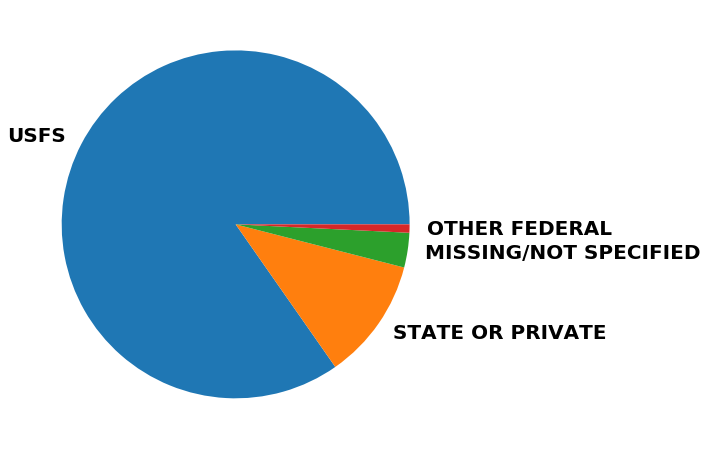

In [24]:
v_owner = owner_land.values() 
k_owner = owner_land.keys()  
f_owner = [float(x) for x in v_owner]  
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.pie(f_owner, labels =k_owner, autopct=None)

plt.show()

([<matplotlib.axis.XTick at 0x2108008c0c8>,
 <a list of 5 Text xticklabel objects>)

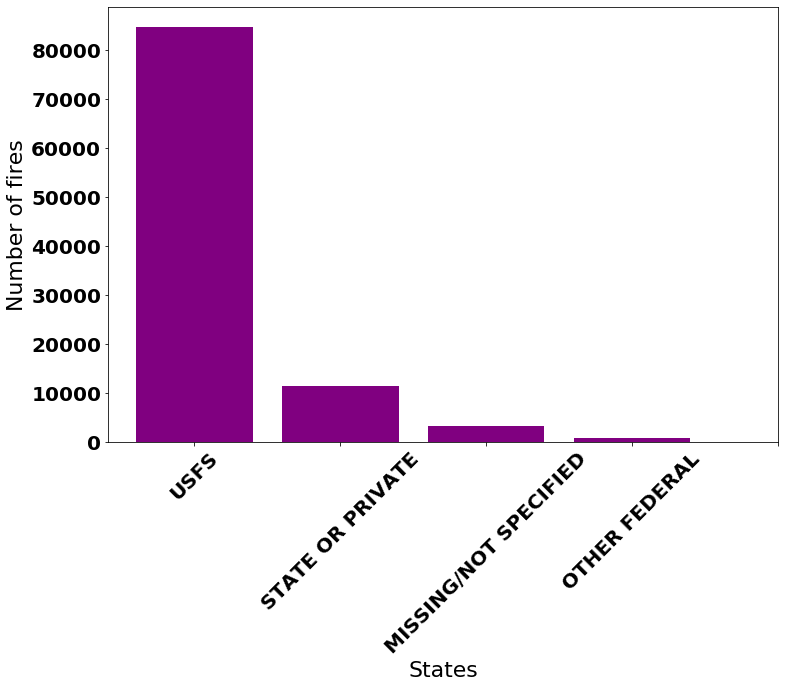

In [262]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.bar(k_owner, f_owner, color = 'purple')
plt.ylabel('Number of fires')
plt.xlabel('States')
plt.xticks(range(0,5), rotation=45)

### Cause of fires

In [25]:
df.STAT_CAUSE_DESCR.value_counts()

Lightning         53475
Campfire          13347
Miscellaneous     11322
Arson              9867
Debris Burning     4537
Equipment Use      3312
Smoking            2533
Children           1117
Railroad            490
Name: STAT_CAUSE_DESCR, dtype: int64

In [26]:
wildfire_cause = {}
for idx, row in df.iterrows():
    a = str(row.STAT_CAUSE_DESCR)
    split = a.split(',')
    for x in split:
        if x in wildfire_cause:
            wildfire_cause[x] += 1
        else: 
            wildfire_cause[x] = 1

In [27]:
wildfire_cause

{'Miscellaneous': 11322,
 'Lightning': 53475,
 'Debris Burning': 4537,
 'Campfire': 13347,
 'Equipment Use': 3312,
 'Arson': 9867,
 'Children': 1117,
 'Railroad': 490,
 'Smoking': 2533}

In [254]:
wildfire_causes_df = pd.DataFrame(wildfire_cause.items(), columns=['Cause of Fire', 'count'])
wildfire_causes_df

,Cause of Fire,count
0,Miscellaneous,11322
1,Lightning,53475
2,Debris Burning,4537
3,Campfire,13347
4,Equipment Use,3312
5,Arson,9867
6,Children,1117
7,Railroad,490
8,Smoking,2533


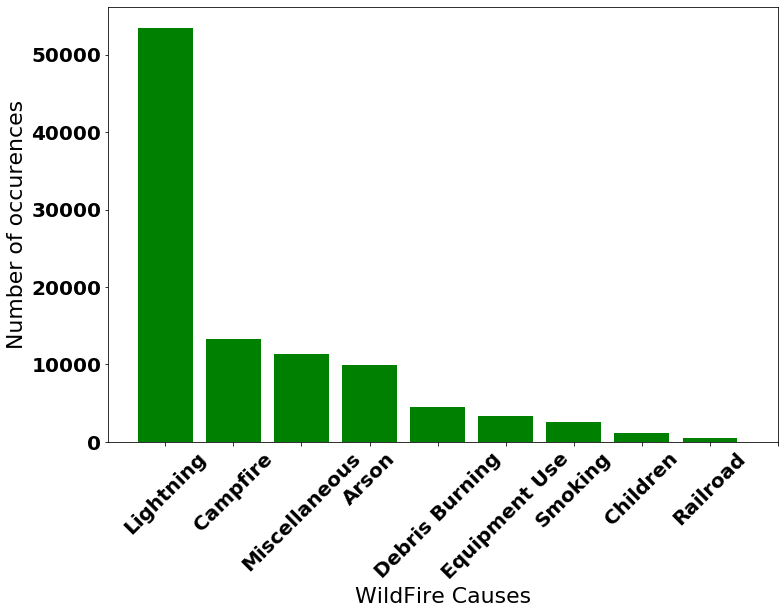

In [259]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.bar(wildfire_causes_df['Cause of Fire'], wildfire_causes_df['count'], color = 'green')
plt.ylabel('Number of occurences')
plt.xlabel('WildFire Causes')
plt.xticks(range(0,10), rotation=45)
plt.savefig('US wildfires')

plt.show()

In [268]:
df

,SOURCE_REPORTING_UNIT_NAME,FIRE_CODE,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE
0,Plumas National Forest,BJ8K,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA
1,Eldorado National Forest,AAC0,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA
2,Eldorado National Forest,A32W,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA
3,Eldorado National Forest,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA
4,Eldorado National Forest,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Mt. Hood National Forest,None,1997,2450691.5,243,1700,1.0,Lightning,2450692.5,244.0,1500,0.10,A,45.048611,-121.769167,5.0,USFS,OR
99996,Plumas National Forest,None,1997,2450685.5,237,1900,9.0,Miscellaneous,2450686.5,238.0,1800,1.00,B,40.016667,-120.753333,5.0,USFS,CA
99997,Plumas National Forest,None,1997,2450691.5,243,1409,9.0,Miscellaneous,2450691.5,243.0,1930,2.00,B,40.056667,-120.225000,5.0,USFS,CA
99998,Plumas National Forest,None,1997,2450692.5,244,1754,1.0,Lightning,2450692.5,244.0,2230,2.00,B,39.985000,-120.133333,5.0,USFS,CA


In [29]:
df1 = df.drop(columns = ['SOURCE_REPORTING_UNIT_NAME', 'FIRE_CODE', 'LATITUDE', 'LONGITUDE'])
df1

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_CODE,OWNER_DESCR,STATE
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,5.0,USFS,CA
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,5.0,USFS,CA
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,13.0,STATE OR PRIVATE,CA
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,5.0,USFS,CA
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,5.0,USFS,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1997,2450691.5,243,1700,1.0,Lightning,2450692.5,244.0,1500,0.10,A,5.0,USFS,OR
99996,1997,2450685.5,237,1900,9.0,Miscellaneous,2450686.5,238.0,1800,1.00,B,5.0,USFS,CA
99997,1997,2450691.5,243,1409,9.0,Miscellaneous,2450691.5,243.0,1930,2.00,B,5.0,USFS,CA
99998,1997,2450692.5,244,1754,1.0,Lightning,2450692.5,244.0,2230,2.00,B,5.0,USFS,CA


In [125]:
df_modeling = encode_me('FIRE_SIZE_CLASS', df1)
df_modeling = encode_me('STATE', df_modeling)
df_modeling

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,OWNER_CODE,OWNER_DESCR,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,FIRE_SIZE_CLASS_F,FIRE_SIZE_CLASS_G,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,STATE_FL,STATE_GA,STATE_ID,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_MT,STATE_NC,STATE_ND,STATE_NE,STATE_NH,STATE_NM,STATE_NV,STATE_NY,STATE_OH,STATE_OK,STATE_OR,STATE_PA,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,13.0,STATE OR PRIVATE,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1997,2450691.5,243,1700,1.0,Lightning,2450692.5,244.0,1500,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
99996,1997,2450685.5,237,1900,9.0,Miscellaneous,2450686.5,238.0,1800,1.00,5.0,USFS,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99997,1997,2450691.5,243,1409,9.0,Miscellaneous,2450691.5,243.0,1930,2.00,5.0,USFS,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99998,1997,2450692.5,244,1754,1.0,Lightning,2450692.5,244.0,2230,2.00,5.0,USFS,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
df_modeling.dropna(inplace=True)

In [32]:
df_modeling.isna().sum()

FIRE_YEAR            0
DISCOVERY_DATE       0
DISCOVERY_DOY        0
DISCOVERY_TIME       0
STAT_CAUSE_CODE      0
STAT_CAUSE_DESCR     0
CONT_DATE            0
CONT_DOY             0
CONT_TIME            0
FIRE_SIZE            0
OWNER_CODE           0
OWNER_DESCR          0
FIRE_SIZE_CLASS_B    0
FIRE_SIZE_CLASS_C    0
FIRE_SIZE_CLASS_D    0
FIRE_SIZE_CLASS_E    0
FIRE_SIZE_CLASS_F    0
FIRE_SIZE_CLASS_G    0
STATE_AL             0
STATE_AR             0
STATE_AZ             0
STATE_CA             0
STATE_CO             0
STATE_FL             0
STATE_GA             0
STATE_ID             0
STATE_IL             0
STATE_IN             0
STATE_KS             0
STATE_KY             0
STATE_LA             0
STATE_ME             0
STATE_MI             0
STATE_MN             0
STATE_MO             0
STATE_MS             0
STATE_MT             0
STATE_NC             0
STATE_ND             0
STATE_NE             0
STATE_NH             0
STATE_NM             0
STATE_NV             0
STATE_NY   

In [126]:
df_modeling

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,OWNER_CODE,OWNER_DESCR,FIRE_SIZE_CLASS_B,FIRE_SIZE_CLASS_C,FIRE_SIZE_CLASS_D,FIRE_SIZE_CLASS_E,FIRE_SIZE_CLASS_F,FIRE_SIZE_CLASS_G,STATE_AL,STATE_AR,STATE_AZ,STATE_CA,STATE_CO,STATE_FL,STATE_GA,STATE_ID,STATE_IL,STATE_IN,STATE_KS,STATE_KY,STATE_LA,STATE_ME,STATE_MI,STATE_MN,STATE_MO,STATE_MS,STATE_MT,STATE_NC,STATE_ND,STATE_NE,STATE_NH,STATE_NM,STATE_NV,STATE_NY,STATE_OH,STATE_OK,STATE_OR,STATE_PA,STATE_SC,STATE_SD,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_VT,STATE_WA,STATE_WI,STATE_WV,STATE_WY
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,13.0,STATE OR PRIVATE,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1997,2450691.5,243,1700,1.0,Lightning,2450692.5,244.0,1500,0.10,5.0,USFS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
99996,1997,2450685.5,237,1900,9.0,Miscellaneous,2450686.5,238.0,1800,1.00,5.0,USFS,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99997,1997,2450691.5,243,1409,9.0,Miscellaneous,2450691.5,243.0,1930,2.00,5.0,USFS,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
99998,1997,2450692.5,244,1754,1.0,Lightning,2450692.5,244.0,2230,2.00,5.0,USFS,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [129]:
df_modeling_y = df_modeling['STAT_CAUSE_CODE']
df_modeling1 = df_modeling.drop(columns=['STAT_CAUSE_DESCR', 'OWNER_DESCR', 'STAT_CAUSE_CODE'])
df_modeling_y

0        9.0
1        1.0
2        5.0
3        1.0
4        1.0
        ... 
99995    1.0
99996    9.0
99997    9.0
99998    1.0
99999    1.0
Name: STAT_CAUSE_CODE, Length: 100000, dtype: float64

# Beginning of Modeling

In [33]:
df_modeling['DISCOVERY_TIME'] = pd.to_numeric(df_modeling['DISCOVERY_TIME'])
df_modeling['CONT_TIME'] = pd.to_numeric(df_modeling['CONT_TIME'])
df_modeling.CONT_TIME.dtype

dtype('int64')

In [121]:
X = df_modeling
y = df_modeling_y

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))


74871 24958 74871 24958


# Decision Tree

### Im looking at a decision tree to have a baseline to how well other models are running and to see the feature importances in this model

#### Model 1

In [269]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_X_preds =  dt.predict(X_test)


In [270]:
dt_report = class_report_todataframe(y_test, dt_X_preds)
dt_report

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.809160,0.126536,0.070423,0.368912,0.318718,0.137681,0.508037,0.062731,0.243961,0.577009,0.294017,0.581254
recall,0.802297,0.123947,0.083195,0.361947,0.335404,0.163793,0.491207,0.060071,0.252287,0.577009,0.297127,0.577009
f1-score,0.805714,0.125228,0.076278,0.365396,0.326848,0.149606,0.499480,0.061372,0.248054,0.577009,0.295331,0.579069
support,13323.000000,831.000000,601.000000,3390.000000,1127.000000,116.000000,2445.000000,283.000000,2842.000000,0.577009,24958.000000,24958.000000


<Figure size 1152x648 with 0 Axes>

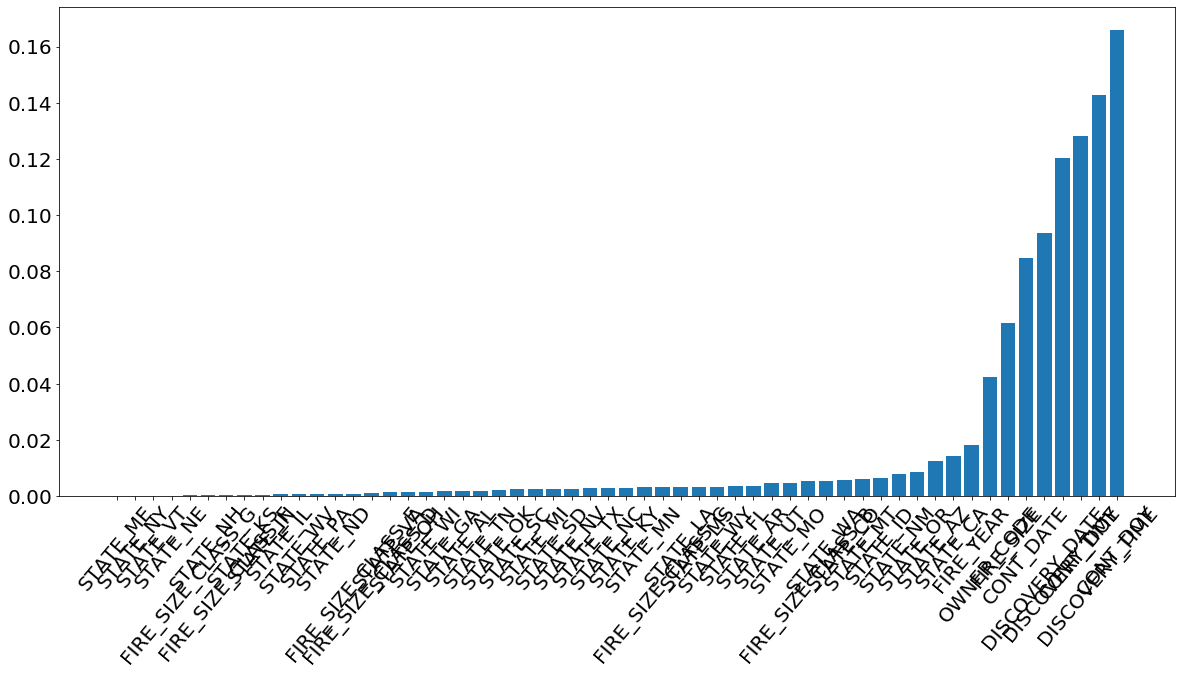

<Figure size 1152x648 with 0 Axes>

In [271]:
feature_model_importances(dt, df_modeling1)

#### Accuracy is .577 and all other metrics are at a .29

# Vanilla Random Forest Model

### Model 2

In [36]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)

rfc_X_test = rfc.predict(X_test)

In [81]:
rfc_report = class_report_todataframe(y_test, rfc_X_test)
rfc_report

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.781027,0.188889,0.106122,0.489788,0.425552,0.523810,0.609485,0.128571,0.347095,0.664076,0.400038,0.614638
recall,0.938077,0.102286,0.043261,0.396165,0.393079,0.094828,0.604499,0.031802,0.239620,0.664076,0.315957,0.664076
f1-score,0.852379,0.132709,0.061466,0.438030,0.408672,0.160584,0.606982,0.050992,0.283514,0.664076,0.332814,0.631935
support,13323.000000,831.000000,601.000000,3390.000000,1127.000000,116.000000,2445.000000,283.000000,2842.000000,0.664076,24958.000000,24958.000000


<Figure size 1152x648 with 0 Axes>

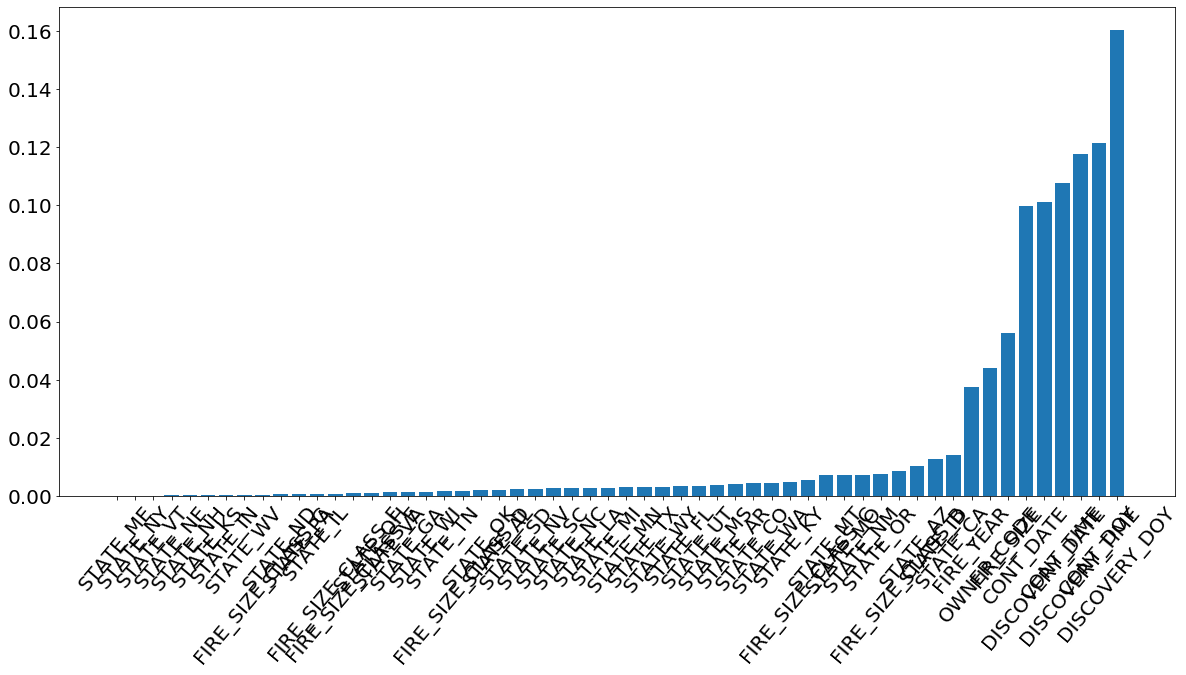

<Figure size 1152x648 with 0 Axes>

In [266]:
feature_model_importances(rfc, df_modeling1)

### There is about a 9 percent increase in accuracy in a vanilla random forest then my baseline model. This models accuracy is a .664

# Random Forest Parameter Tuned

#### Model 3 tuned with accuracy

I kept deleting my parameters while narrowing down best parameters. It was originally: 

``` 
rfc_param = {'n_estimators' : [1,50,100],
        'max_depth' : [1,50,100],
        'min_samples_split' : [0.0,1,2]} 
```
If my best estimator was leaning on the higher end I would delete everything else and then keep the best estimator in each of the hyperparameters in and inset new ones. parameter 

In [296]:
rfc_param= {'n_estimators' : [195,225,255],
        'max_depth' : [49,50,51,52,53],
        'min_samples_split' : [.00018,.0002,.00021]} 

rfc_pmtuned = RandomForestClassifier()

grid_rfc = GridSearchCV(rfc_pmtuned, rfc_param, cv=3,
                        scoring= "accuracy")

grid_rfc = grid_rfc.fit(X_train, y_train)

In [297]:
grid_rfc_X_test = grid_rfc.predict(X_test)

In [298]:
class_report_todataframe(y_test, grid_rfc_X_test)

C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.765103,0.272727,0.0,0.540883,0.484694,1.000000,0.643936,0.0,0.372483,0.68435,0.453314,0.623005
recall,0.962021,0.025271,0.0,0.415634,0.421473,0.034483,0.644990,0.0,0.273399,0.68435,0.308586,0.684350
f1-score,0.852336,0.046256,0.0,0.470058,0.450878,0.066667,0.644463,0.0,0.315341,0.68435,0.316222,0.640091
support,13323.000000,831.000000,601.0,3390.000000,1127.000000,116.000000,2445.000000,283.0,2842.000000,0.68435,24958.000000,24958.000000


In [223]:
rfc_best = grid_rfc.best_estimator_

<Figure size 1152x648 with 0 Axes>

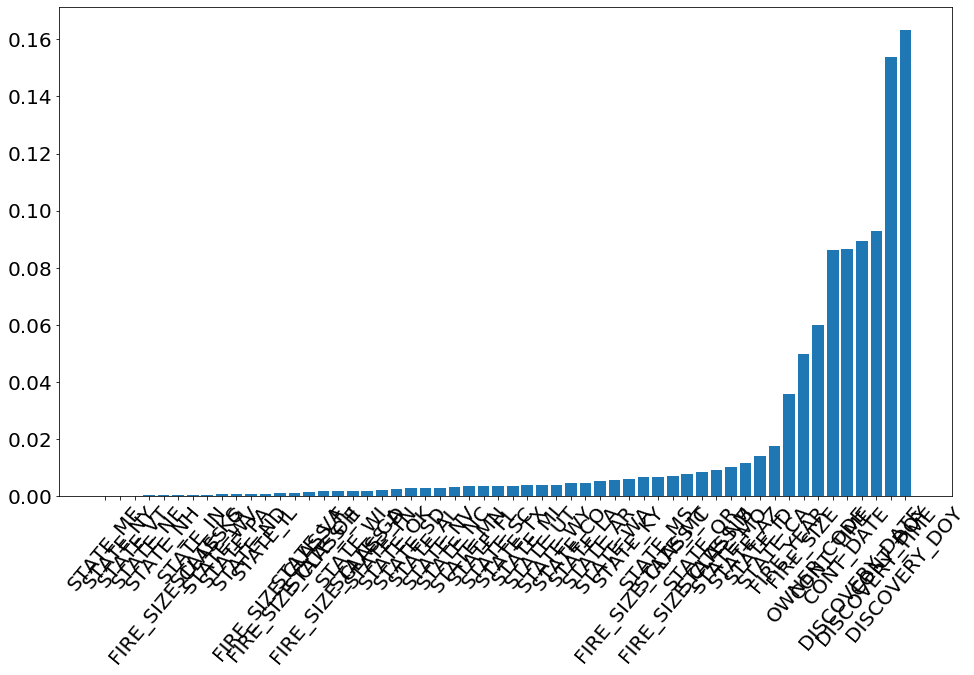

<Figure size 1152x648 with 0 Axes>

In [194]:
feature_model_importances(rfc_best, df_modeling1)

### This hyperparameter tuned model has an increase in accuracy by 2 percent which mean it is doing a better job than the vanilla model.

# AdaBoost Model

#### Model 4 adaboost tuned on accuracy

In [47]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
ada_X_test = adaboost.predict(X_test)

In [48]:
class_report_todataframe(y_test, ada_X_test)

C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.688675,0.222222,0.0,0.417469,0.454647,0.0,0.618512,0.0,0.313337,0.631902,0.301651,0.548532
recall,0.959844,0.002407,0.0,0.179056,0.360248,0.0,0.584867,0.0,0.189303,0.631902,0.252858,0.631902
f1-score,0.801957,0.004762,0.0,0.250619,0.401980,0.0,0.601219,0.0,0.236017,0.631902,0.255173,0.566223
support,13323.000000,831.000000,601.0,3390.000000,1127.000000,116.0,2445.000000,283.0,2842.000000,0.631902,24958.000000,24958.000000


<Figure size 1152x648 with 0 Axes>

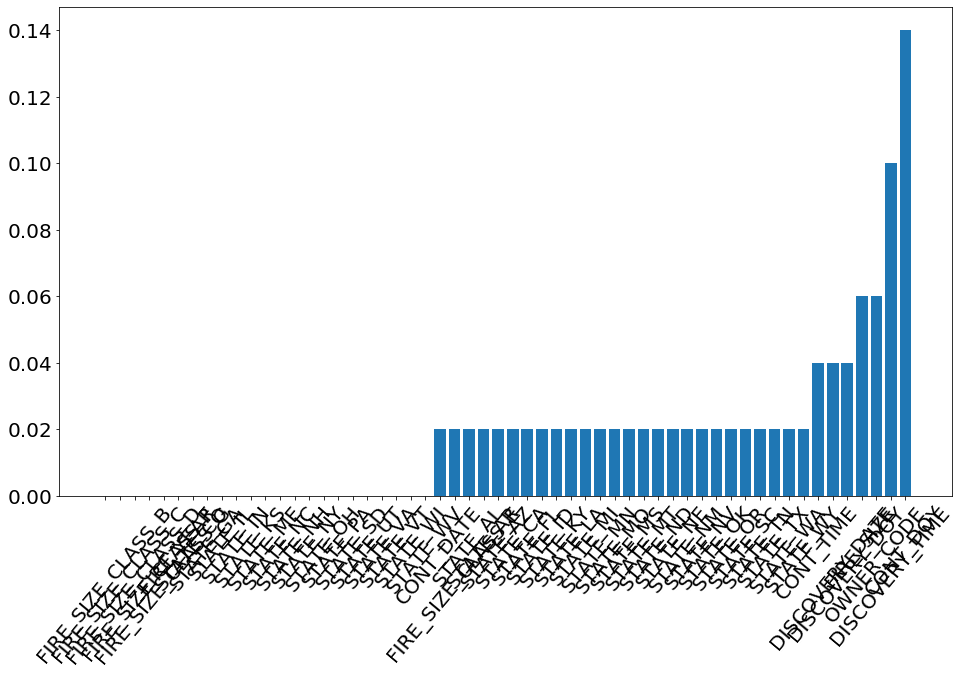

<Figure size 1152x648 with 0 Axes>

In [155]:
feature_model_importances(adaboost, df_modeling1)

### The ada boost model is doing worse than the vanilla random forest and the hyper parameter tuned random forest in all metrics. Its accuracy is 5 percent lower than the random forest hyper parameter tuned. This model's accuracy is a .631 .

## Adaboost with Grid Search

#### Model 5 grid searched on accuracy

In [225]:
abc_param = {'learning_rate': [1.74,1.75,1.76],
             'n_estimators': [400,450,500]}

abc = AdaBoostClassifier(algorithm = 'SAMME')

abc_grid = GridSearchCV(abc ,abc_param, cv=3).fit(X_train, y_train)

In [226]:
abc_grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.75,
                   n_estimators=500, random_state=None)

In [228]:
abc_X_test = abc_grid.best_estimator_.predict(X_test)

In [230]:
class_report_todataframe(y_test, abc_X_test)

C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.689674,0.250000,0.0,0.423718,0.472401,0.0,0.591561,0.0,0.303210,0.630499,0.303396,0.547847
recall,0.955491,0.007220,0.0,0.187611,0.326531,0.0,0.607771,0.0,0.179451,0.630499,0.251564,0.630499
f1-score,0.801108,0.014035,0.0,0.260070,0.386149,0.0,0.599556,0.0,0.225464,0.630499,0.254042,0.565283
support,13323.000000,831.000000,601.0,3390.000000,1127.000000,116.0,2445.000000,283.0,2842.000000,0.630499,24958.000000,24958.000000


### There is no change in metrics compared to the vanilla AdaBoost model.

# Random forest grid searched

### Model 6 grid searched on precision

#### In my modeling I want to focus on Precision metric since in this bussiness case it would be more important to have my models correctly predict a cause of a fire for an insurance company to minimize the cost of investigating a cause of a fire. 

Original parameters I started was:
   
   ```
    rfc_param_prec = {'n_estimators' : [1,50,100],
        'max_depth' : [1,50,100],
        'min_samples_split' : [0.0,1,2]}
   ```


In [349]:
rfc_param_prec = {'n_estimators' : [200,250,300],
        'max_depth' : [55,56,57],
        'min_samples_split' : [6,8,10]}

rfc_pmtuned_prec = RandomForestClassifier()

grid_rfc_prec = GridSearchCV(rfc_pmtuned_prec, rfc_param_prec, cv=3,
                        scoring= "precision_macro") #Score function for my grid searches to look for

grid_rfc_prec = grid_rfc_prec.fit(X_train, y_train)

In [350]:
grid_rfc_prec.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=56, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [351]:
prec_rfc_X_test = grid_rfc_prec.best_estimator_.predict(X_test)

In [352]:
class_report_todataframe(y_test, prec_rfc_X_test)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.772047,0.254717,0.050000,0.544294,0.495327,1.000000,0.648616,1.000000,0.372748,0.687555,0.570861,0.640088
recall,0.960670,0.032491,0.001664,0.427729,0.423248,0.043103,0.651534,0.003534,0.283955,0.687555,0.314214,0.687555
f1-score,0.856092,0.057631,0.003221,0.479022,0.456459,0.082645,0.650071,0.007042,0.322349,0.687555,0.323837,0.645523
support,13323.000000,831.000000,601.000000,3390.000000,1127.000000,116.000000,2445.000000,283.000000,2842.000000,0.687555,24958.000000,24958.000000


In [353]:
rfc_best_prec = grid_rfc_prec.best_estimator_

<Figure size 1152x648 with 0 Axes>

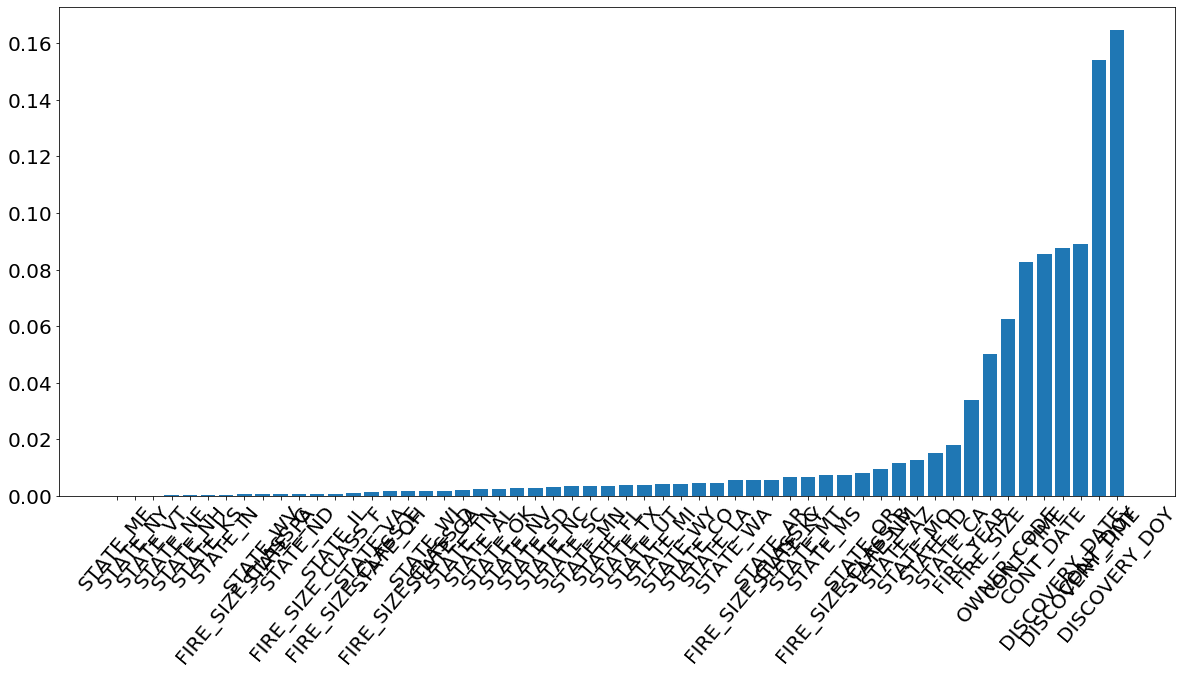

<Figure size 1152x648 with 0 Axes>

In [378]:
feature_model_importances(rfc_best_prec, df_modeling1)

### This Model did significantly better than the hyperparameter random forest (model 3). This model gave a precision score of .570 compared to model 3 where it only had a precision score of .45. That is a 12 percent increase!

# AdaBoost grid searched

### Model 7 grid searched on precision

In [355]:
abc_param_prec = {'learning_rate': [2,3],
             'n_estimators': [475,500,525]}

abc_prec = AdaBoostClassifier(algorithm = 'SAMME')

abc_grid_prec = GridSearchCV(abc_prec ,abc_param_prec, cv=3, scoring = "precision_macro").fit(X_train, y_train)

C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\artur\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\artur\Anaconda3\lib\site-packages\sklearn\m

In [356]:
abc_grid.best_estimator_

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=2,
                   n_estimators=500, random_state=None)

In [357]:
abc_prec_X_test = abc_grid_prec.best_estimator_.predict(X_test)

In [358]:
class_report_todataframe(y_test, abc_prec_X_test)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.711590,0.250000,0.157895,0.402137,0.443228,0.0,0.556814,0.166667,0.285998,0.626052,0.330481,0.555626
recall,0.931322,0.012034,0.004992,0.244248,0.287489,0.0,0.603272,0.003534,0.202674,0.626052,0.254396,0.626052
f1-score,0.806762,0.022962,0.009677,0.303909,0.348762,0.0,0.579113,0.006920,0.237232,0.626052,0.257260,0.572514
support,13323.000000,831.000000,601.000000,3390.000000,1127.000000,116.0,2445.000000,283.000000,2842.000000,0.626052,24958.000000,24958.000000


<Figure size 1152x648 with 0 Axes>

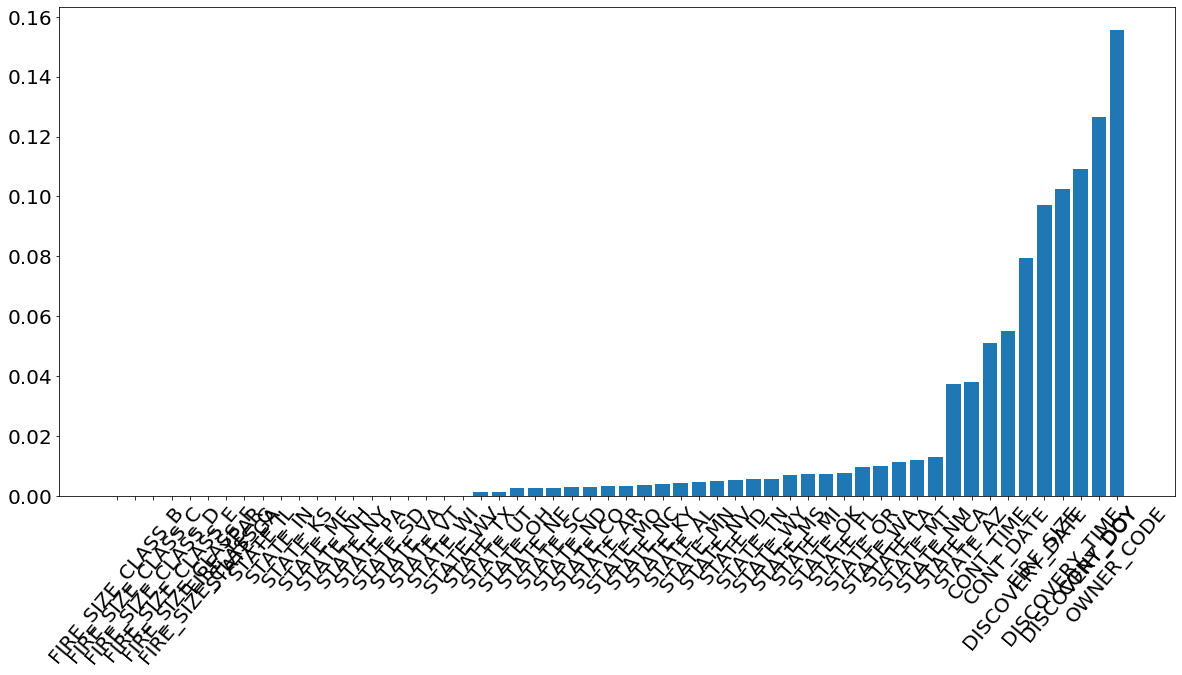

<Figure size 1152x648 with 0 Axes>

In [359]:
abc_feature = abc_grid.best_estimator_

feature_model_importances(abc_feature, df_modeling1)

### This model did worse than my previous model which is the random forest and had a 24 percent decrease in precision. This models precision score is a .33 while the previous is a .57

# XGBoost Vanilla Model

### model 8

In [69]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_X_test = xg.predict(X_test)

In [70]:
xg_report = class_report_todataframe(y_test, xg_X_test)
xg_report

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,accuracy,macro avg,weighted avg
precision,0.778213,0.275676,0.171429,0.529263,0.489614,0.615385,0.651723,0.142857,0.365753,0.685672,0.446657,0.632703
recall,0.954440,0.061372,0.009983,0.432153,0.439219,0.068966,0.642127,0.003534,0.281844,0.685672,0.321515,0.685672
f1-score,0.857364,0.100394,0.018868,0.475804,0.463050,0.124031,0.646889,0.006897,0.318362,0.685672,0.334629,0.647289
support,13323.000000,831.000000,601.000000,3390.000000,1127.000000,116.000000,2445.000000,283.000000,2842.000000,0.685672,24958.000000,24958.000000


<Figure size 1152x648 with 0 Axes>

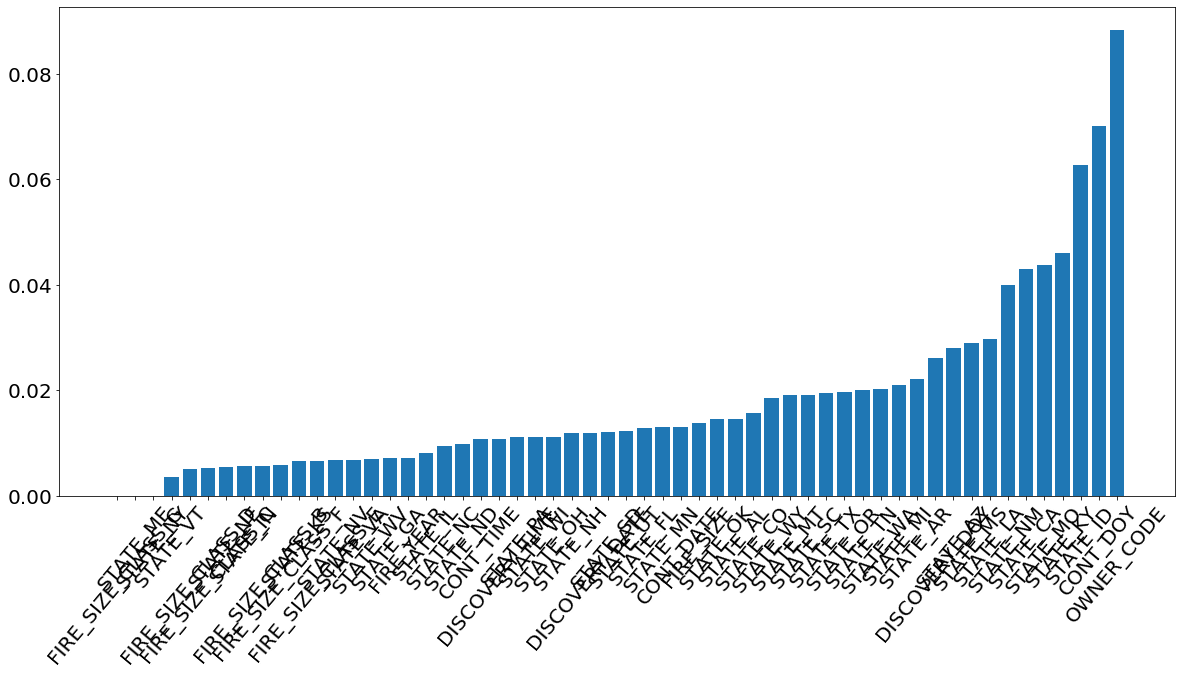

<Figure size 1152x648 with 0 Axes>

In [267]:
feature_model_importances(xg, df_modeling1)

### XGBoost was ran before the precision models but was still valueable to look at how it was doing in accuracy which it was doing worse than random forest both hyper parameter tuned and vanilla but better than adaboost. Its precision was worse than the hyper parameter random forest tuned to precision but did better than every other models' precision score. The precision score for the XGBoostClassifier model is a .446.

# Future Work

I want to run a nueral network model to see if it can do a better job classifying my target variable. I want to see if can sample more data for other causes of fires that is less than lightining to see if having more observations can help improve my scores. The use of PCA (principal component analysis) maybe useful here to reduce dimesionality. I want to see if using that can help improve my precision scores across my models. I want to see if the use of clustering may also be useful to improve my scores. I will see if I can just change my target varaiable to human causes and nature causes of wildfire and see if that will help improve my scores which would still be useful information for insurers to see if it is worth investigating. Create an ineractive map for users can see previous fires and information about those fires. 

Additionaly, I need to build my own grid search since the sklearn version of grid search was not getting along well with the XGBoostClassifier.